# CS5014 - Data Science

## Final Project

---

**Student Name:** Michael Nolan

**Student Number:** 18200079

**Student Email:** 18200079@studentmail.ul.ie

---

## Project 5 algorithmic fairness

Algorithm fairness is becoming a fundamental topic in ML. It is a complex ethical task to define what fairness is/means. Once we have defined quantitatively what fairness is then, from a mathematical perspective, the problem of  algorithmic fairness is very clear: it is a multi-objective optimization problem. There are multi objectives that we aim to optimize during data fitting, e.g., accuracy and fairness.

The goal of this project is to implement from scratch the "fair" **linear and nonlinear SVM** described in the following paper (see in particular Appendix A that reports the optimization problem)  

["Fairness Constraints: Mechanisms for Fair Classification"](https://arxiv.org/pdf/1507.05259.pdf)

and reproduce the experiments reported in the paper. In particular, apply your method to the Adult and Bank 
data sets.

Your notebook must include:
* a description (summary) of the algorithm presented in the above paper (focusing on SVM), similar to the theoretical details of logistic regression I wrote at the beginning of the notebook for e-tivity Task A (week 1&2). The reader must understand from your explanation the difference between standard SVM and the "fair" SVM.
* You implementation of the "fair" **linear and nonlinear SVM** using CVXOPT to solve data fitting (as I have shown in Week 3 webinar, see also example below). You should implement it as a Python class (similar to logistic regression class for E-tivity 1).
* A test of the input-output behavior of your algorithm. More clearly, you have to replicate the experiment results you find in Section 4.1 for Synthetic Data and Section 4.2 of the above paper for the Adult and Bank data sets.


Resources:
* Week 3 webinar slides with the details of the SVM algorithm;
* [Example](https://xavierbourretsicotte.github.io/SVM_implementation.html) about how to use the library CVXOPT to implement data fitting for standard SVM
* [fairness-in-machine-learning](https://towardsdatascience.com/a-tutorial-on-fairness-in-machine-learning-3ff8ba1040cb)
* (Optional) Multi-objective optimization and Pareto optimality see Book chapter 12 (of our Module's book).

**How to approach the problem** (this is just a suggestion).

You can start implementing linear SVM and apply it to the Synthetic Data experiment in Section 4.1 so that you can plot the classification line for standard linear SVM versus fair linear SVM.

## Notes from Paper

- Sensitive features are removed from decision making
   - This accounts for _disparate treatment_
- Add fairness constraints for training
   - This accounts for _disparate impact_
   
## General Notes

- Use StandardScaler
- Need to put constraint into $G$ and $h$ matrices. (left side of $G$ / right side of $h$ see formula below

$ \dfrac{1}{N} \sum_{i=1}^N (z_i - \bar{z}) \theta^T x_i \leq c $


## Alessio's Cost Function Update

$$
\min - \sum_{i=1}^n \alpha_i + \sum_{i=1}^n \alpha_i y_i (g_{\alpha}(x)+h_{\alpha}(x))
$$

## Imports

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import numpy as np
import cvxopt

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()

## SVM Class

- SVM class provided by Alessio which is from MLFromScratch.

_N.B.: mlfromscratch needs to be installed. Instructions can be found at the link below._

In [ ]:
'''Linear Kernel'''
def linear_kernel(x1, x2):
    return np.inner(x1, x2)

def rbf_kernel(x1, x2, gamma):
    dist = np.linalg.norm(x1, x2) ** 2
    return np.exp(-gamma * dist)

class SupportVectorMachine(object):
    
    def __init__(self, C=1, kernel=rbf_kernel, gamma=None):
        self.C = C
        self.kernel = kernel
        self.gamma = gamma
        self.lagr_multipliers = None
        self.support_vectors = None
        self.support_vector_labels = None
        self.intercept = None
    
    def fit(X, y):
        # CVXOPT Setup
        cvxopt.solvers.options['show_progress'] = False # Hide cvxopt output
        cvxopt.solvers.options['abstol'] = 1e-10
        cvxopt.solvers.options['reltol'] = 1e-10
        cvxopt.solvers.options['feastol'] = 1e-10
        
        n_samples, n_features = np.shape(X)
        
        if not self.gamma:
            self.gamma = 1 / n_features

In [76]:
# mlfromscratch install instructions can be found here:
# https://github.com/eriklindernoren/ML-From-Scratch#installation

from __future__ import division, print_function
from mlfromscratch.utils.kernels import *



class SupportVectorMachine(object):
    """The Support Vector Machine classifier.
    Uses cvxopt to solve the quadratic optimization problem.

    Parameters:
    -----------
    C: float
        Penalty term.
    kernel: function
        Kernel function. Can be either polynomial, rbf or linear.
    power: int
        The degree of the polynomial kernel. Will be ignored by the other
        kernel functions.
    gamma: float
        Used in the rbf kernel function.
    coef: float
        Bias term used in the polynomial kernel function.
    """
    def __init__(self, C=1, kernel=rbf_kernel, power=4, gamma=None, coef=4):
        self.C = C
        self.kernel = kernel
        self.power = power
        self.gamma = gamma
        self.coef = coef
        self.lagr_multipliers = None
        self.support_vectors = None
        self.support_vector_labels = None
        self.intercept = None

    def fit(self, X, y, Z=None):

        n_samples, n_features = np.shape(X)

        # Set gamma to 1/n_features by default
        if not self.gamma:
            self.gamma = 1 / n_features

        # Initialize kernel method with parameters
        self.kernel = self.kernel(
            power=self.power,
            gamma=self.gamma,
            coef=self.coef)

        # Calculate kernel matrix
        kernel_matrix = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                kernel_matrix[i, j] = self.kernel(X[i], X[j])
        
        G_max = np.identity(n_samples) * -1
        G_min = np.identity(n_samples)
        
        h_max = cvxopt.matrix(np.zeros(n_samples))
        h_min = cvxopt.matrix(np.ones(n_samples) * self.C)
        
        if Z is not None:
            Z_norm = Z - np.mean(Z)
            fair_const = (1 / n_samples) * (np.dot(Z_norm, y.T) * kernel_matrix)

#             P = 2 * cvxopt.matrix(np.outer(y, y) * kernel_matrix + np.outer(y, y) * np.eye(n_samples), tc='d')
            P = cvxopt.matrix(2 * ((kernel_matrix + (1/C) * (np.eye(n_samples))) * (y.dot(y.T))), tc='d')
            
            G_1 = cvxopt.matrix(fair_const, tc='d')
            G_2 = cvxopt.matrix(-fair_const, tc='d')
            G = cvxopt.matrix(np.vstack((G_max, G_min, G_1, G_2)))
            
            h_1 = cvxopt.matrix(np.ones(n_samples) * self.C, tc='d')
            h = cvxopt.matrix(np.vstack((h_max, h_min, h_1)))
        else:
            P = cvxopt.matrix(np.outer(y, y) * kernel_matrix, tc='d')
            G = cvxopt.matrix(np.vstack((G_max, G_min)))
            h = cvxopt.matrix(np.vstack((h_max, h_min)))

        # Define the quadratic optimization problem
#         P = cvxopt.matrix(np.outer(y, y) * kernel_matrix, tc='d')
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1, n_samples), tc='d')
        b = cvxopt.matrix(0, tc='d')
        
#         G_max = np.identity(n_samples) * -1
#         G_min = np.identity(n_samples)
#         G_1 = cvxopt.matrix(fair_const)
#         G_2 = cvxopt.matrix(-fair_const)
#         G = cvxopt.matrix(np.vstack((G_max, G_min, G_1, G_2)))
#         h_max = cvxopt.matrix(np.zeros(n_samples))
#         h_min = cvxopt.matrix(np.ones(n_samples) * self.C)
#         h_1 = cvxopt.matrix(np.ones(n_samples) * self.C)
#         h = cvxopt.matrix(np.vstack((h_max, h_min)))

#         if not self.C:
#             G = cvxopt.matrix(np.identity(n_samples) * -1)
#             h = cvxopt.matrix(np.zeros(n_samples))
#         else:
#             print("C is set")
#             G_max = np.identity(n_samples) * -1
#             G_min = np.identity(n_samples)
#             G_1 = cvxopt.matrix(fair_const)
#             G_2 = cvxopt.matrix(-fair_const)
#             G = cvxopt.matrix(np.vstack((G_max, G_min, G_1, G_2)))
#             h_max = cvxopt.matrix(np.zeros(n_samples))
#             h_min = cvxopt.matrix(np.ones(n_samples) * self.C)
#             h_1 = cvxopt.matrix(np.ones(n_samples) * self.C)
#             h = cvxopt.matrix(np.vstack((h_max, h_min)))

        # Solve the quadratic optimization problem using cvxopt
        minimization = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        lagr_mult = np.ravel(minimization['x'])

        # Extract support vectors
        # Get indexes of non-zero lagr. multipiers
        idx = lagr_mult > 1e-7
        # Get the corresponding lagr. multipliers
        self.lagr_multipliers = lagr_mult[idx]
        # Support vector indices
        self.support = idx
        # Get the samples that will act as support vectors
        self.support_vectors = X[idx]
        # Get the corresponding labels
        self.support_vector_labels = y[idx]
        
        #coef
        self.w = ((y * lagr_mult).T @ X)
        self.b = y[idx] - np.dot(X[idx], self.w)

        # Calculate intercept with first support vector
        self.intercept = self.support_vector_labels[0]
        for i in range(len(self.lagr_multipliers)):
            self.intercept -= self.lagr_multipliers[i] * self.support_vector_labels[i] * self.kernel(self.support_vectors[i], self.support_vectors[0])

    def predict(self, X):
        y_pred = []
        # Iterate through list of samples and make predictions
        for sample in X:
            prediction = 0
            # Determine the label of the sample by the support vectors
            for i in range(len(self.lagr_multipliers)):
                prediction += self.lagr_multipliers[i] * self.support_vector_labels[i] * self.kernel(self.support_vectors[i], sample)
            prediction += self.intercept
            y_pred.append(np.sign(prediction))
        return np.array(y_pred)

## Load / Preprocess Data

- Load the bank dataset
- Pull target variable, `y`, out and change to binary: `['yes', 'no']` to `[1, -1]`
- Dummy categorical data.
   - `['yes', 'no']` to `[1, 0]`
   - Non-binary categorical data will be encoded using `pandas.get_dummies()`
- Pull `age` out as it is the single sensitive feature; `Z`
   - `age` also needs to be updated to binary; `(Z >= 25) & (Z <= 60) = 1`, `0` otherwise
- Scale remaining numeric data using `StandardScaler`

In [3]:
# Paths for data
ds_dir = 'data/'
bank_dir = ds_dir + 'bank/bank/'
adult_dir = ds_dir + 'adult/'

# Load Bank dataset
bank_df = pd.read_csv(bank_dir + 'bank.csv', sep=";")
bank_df.head()

age          job  marital  education default  balance housing loan  \
0   30   unemployed  married    primary      no     1787      no   no   
1   33     services  married  secondary      no     4789     yes  yes   
2   35   management   single   tertiary      no     1350     yes   no   
3   30   management  married   tertiary      no     1476     yes  yes   
4   59  blue-collar  married  secondary      no        0     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome   y  
0  cellular   19   oct        79         1     -1         0  unknown  no  
1  cellular   11   may       220         1    339         4  failure  no  
2  cellular   16   apr       185         1    330         1  failure  no  
3   unknown    3   jun       199         4     -1         0  unknown  no  
4   unknown    5   may       226         1     -1         0  unknown  no

In [4]:
# Remove duration as stated in the decription of the Bank dataset:
# https://archive.ics.uci.edu/ml/datasets/Bank+Marketing
# 1 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
bank_df.drop(columns='duration', inplace=True)

In [5]:
# Change age to binary type
idx_1 = bank_df['age'][(bank_df['age'] >= 25) & (bank_df['age'] <= 60)].index
idx_less_25 = bank_df['age'][bank_df['age'] < 25].index
idx_gr_60 = bank_df['age'][bank_df['age'] > 60].index

bank_df.loc[idx_1, 'age'] = 1
bank_df.loc[idx_less_25, 'age'] = 0
bank_df.loc[idx_gr_60, 'age'] = 0

# Create 'y' and change from categorical ['yes', 'no'] to binary [1, -1]
# Printing binary counts to ensure correct replacement
print("'yes' count:", np.sum(bank_df.y == 'yes'))
print("'no' count:", np.sum(bank_df.y == 'no'))

y = bank_df.y.replace({'no':-1, 'yes':1})

print("'1' count:", np.sum(y == 1))
print("'-1' count:", np.sum(y == -1))

# Create X and drop 'y' (target) column
X = bank_df.drop(columns='y', axis=1)

# Let's have a look at X now that we have removed columns
X.head()

'yes' count: 521
'no' count: 4000
'1' count: 521
'-1' count: 4000


age          job  marital  education default  balance housing loan  \
0    1   unemployed  married    primary      no     1787      no   no   
1    1     services  married  secondary      no     4789     yes  yes   
2    1   management   single   tertiary      no     1350     yes   no   
3    1   management  married   tertiary      no     1476     yes  yes   
4    1  blue-collar  married  secondary      no        0     yes   no   

    contact  day month  campaign  pdays  previous poutcome  
0  cellular   19   oct         1     -1         0  unknown  
1  cellular   11   may         1    339         4  failure  
2  cellular   16   apr         1    330         1  failure  
3   unknown    3   jun         4     -1         0  unknown  
4   unknown    5   may         1     -1         0  unknown

In [6]:
# Define arrays of columns with categorical data and columns with numerical data that needs to be scaled.
categorical_cols = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
numeric_cols = ['balance', 'day', 'campaign', 'pdays', 'previous']

In [7]:
# Change categorical binary to numerical binary as was done for 'y'
binary_cols = ['default', 'housing', 'loan']
for col in binary_cols:
    X[col].replace({'no':0, 'yes':1}, inplace=True)
    
X_dummy = pd.get_dummies(X, columns=categorical_cols)
X_dummy.head()

age  default  balance  housing  loan  day  campaign  pdays  previous  \
0    1        0     1787        0     0   19         1     -1         0   
1    1        0     4789        1     1   11         1    339         4   
2    1        0     1350        1     0   16         1    330         1   
3    1        0     1476        1     1    3         4     -1         0   
4    1        0        0        1     0    5         1     -1         0   

   job_admin.  ...  month_jun  month_mar  month_may  month_nov  month_oct  \
0           0  ...          0          0          0          0          1   
1           0  ...          0          0          1          0          0   
2           0  ...          0          0          0          0          0   
3           0  ...          1          0          0          0          0   
4           0  ...          0          0          1          0          0   

   month_sep  poutcome_failure  poutcome_other  poutcome_success  \
0          0                 0               0                 0   
1          0                 1               0                 0   
2          0                 1               0                 0   
3          0                 0               0                 0   
4          0                 0               0                 0   

   poutcome_unknown  
0                 1  
1                 0  
2                 0  
3                 1  
4                 1  

[5 rows x 47 columns]

In [8]:
# Pull sensitive feature ('age') out into Z variable
Z = X_dummy['age']

# Drop age from X_dummy
# X_dummy = X_dummy.drop(columns='age', axis=1)
# X_dummy.head()

In [9]:
# Scale X numerical columns
scaler = StandardScaler()
X_dummy[numeric_cols] = scaler.fit_transform(X_dummy[numeric_cols].astype('float64'))
X_dummy.head()

age  default   balance  housing  loan       day  campaign     pdays  \
0    1        0  0.121072        0     0  0.374052 -0.576829 -0.407218   
1    1        0  1.118644        1     1 -0.596026 -0.576829  2.989044   
2    1        0 -0.024144        1     0  0.010273 -0.576829  2.899143   
3    1        0  0.017726        1     1 -1.566105  0.387967 -0.407218   
4    1        0 -0.472753        1     0 -1.323585 -0.576829 -0.407218   

   previous  job_admin.  ...  month_jun  month_mar  month_may  month_nov  \
0 -0.320413           0  ...          0          0          0          0   
1  2.041734           0  ...          0          0          1          0   
2  0.270124           0  ...          0          0          0          0   
3 -0.320413           0  ...          1          0          0          0   
4 -0.320413           0  ...          0          0          1          0   

   month_oct  month_sep  poutcome_failure  poutcome_other  poutcome_success  \
0          1          0                 0               0                 0   
1          0          0                 1               0                 0   
2          0          0                 1               0                 0   
3          0          0                 0               0                 0   
4          0          0                 0               0                 0   

   poutcome_unknown  
0                 1  
1                 0  
2                 0  
3                 1  
4                 1  

[5 rows x 47 columns]

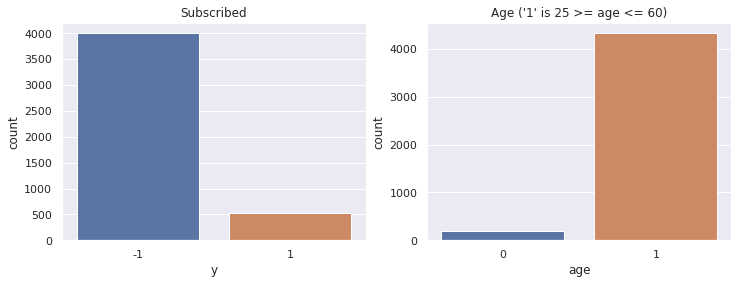

In [10]:
# Plot 'subscribed' and 'age' to see if there is any correlation.
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title('Subscribed')
sns.countplot(y)

plt.subplot(122)
plt.title('Age (\'1\' is 25 >= age <= 60)')
sns.countplot(X_dummy['age'])
_ = plt.plot()

It appears there is a correlation between being in the 25 - 60 age bracket and not subscribing.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_dummy, y, test_size=0.33, random_state=42)

# Pull age out for Z_train
# Z_train = X_train['age']
# Z_test = X_test['age']

# # Drop age from X_train
# X_train.drop(columns='age', inplace=True)
# X_test.drop(columns='age', inplace=True)

In [ ]:
svm = SupportVectorMachine()
svm.fit(X_train.to_numpy(), y_train.to_numpy())
y_pred = svm.predict(X_test.to_numpy())

accuracy_score(y_test, y_pred)

In [ ]:
plt.figure(figsize=(17, 4))
plt.subplot(131)
plt.title('Predictions')
sns.countplot(y_pred)

plt.subplot(132)
plt.title('Y test truth')
sns.countplot(y_test)

plt.subplot(133)
plt.title('Age')
sns.countplot(X_test['age'])
_ = plt.plot()

In [ ]:
svm.support_vectors

In [ ]:
from sklearn.svm import SVC
sk_svc = SVC(gamma='auto')
sk_svc.fit(X_train, y_train)
y_pred_svc = sk_svc.predict(X_test)

accuracy_score(y_test, y_pred_svc)

In [ ]:
print(sk_svc.support_vectors_)

## Synthetic Data

In [142]:
import math
import numpy as np
import matplotlib.pyplot as plt # for plotting stuff
from random import seed, shuffle
from scipy.stats import multivariate_normal # generating synthetic data
SEED = 1122334455
seed(SEED) # set the random seed so that the random permutations can be reproduced again
np.random.seed(SEED)

def plot(X, y, x_control, num_draw=0, support_vectors=None):
    if num_draw > 0:
        x_draw = X[:num_to_draw]
        y_draw = y[:num_to_draw]
        x_control_draw = x_control[:num_to_draw]
    else:
        x_draw = X
        y_draw = y
        x_control_draw = x_control
    
    plt.figure(figsize=(12, 8))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='cividis')
    
    if support_vectors is not None:
        plt.scatter(support_vectors[:, 0], support_vectors[:, 1], color='black', marker='*')
    
    plt.show()
    

def plot_synthetic_data(X, y, x_control, support_vectors=None, num_to_draw=200):
    # we will only draw a small number of points to avoid clutter
    x_draw = X[:num_to_draw]
    y_draw = y[:num_to_draw]
    x_control_draw = x_control[:num_to_draw]

    X_s_0 = x_draw[x_control_draw == 0.0]
    X_s_1 = x_draw[x_control_draw == 1.0]
    y_s_0 = y_draw[x_control_draw == 0.0]
    y_s_1 = y_draw[x_control_draw == 1.0]
    plt.figure(figsize=(10, 7))
    plt.scatter(X_s_0[y_s_0==1.0][:, 0], X_s_0[y_s_0==1.0][:, 1], color='blue', marker='x', s=30, linewidth=1.5, label= "Prot. +ve")
    plt.scatter(X_s_0[y_s_0==-1.0][:, 0], X_s_0[y_s_0==-1.0][:, 1], color='red', marker='x', s=30, linewidth=1.5, label = "Prot. -ve")
    plt.scatter(X_s_1[y_s_1==1.0][:, 0], X_s_1[y_s_1==1.0][:, 1], color='blue', marker='o', facecolors='none', s=30, label = "Non-prot. +ve")
    plt.scatter(X_s_1[y_s_1==-1.0][:, 0], X_s_1[y_s_1==-1.0][:, 1], color='red', marker='o', facecolors='none', s=30, label = "Non-prot. -ve")
    
    if support_vectors is not None:
        plt.scatter(support_vectors[:, 0], support_vectors[:, 1], color='black', marker='*')
#     plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) # dont need the ticks to see the data distribution
#     plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
#     plt.legend(loc=2, fontsize=15)
#     plt.xlim((-15,10))
#     plt.ylim((-10,15))
#     plt.savefig("img/data.png")
    plt.show()

def generate_synthetic_data(plot_data=False):

    """
        Code for generating the synthetic data.
        We will have two non-sensitive features and one sensitive feature.
        A sensitive feature value of 0.0 means the example is considered to be in protected group (e.g., female) and 1.0 means it's in non-protected group (e.g., male).
    """

    n_samples = 1000 # generate these many data points per class
    disc_factor = math.pi / 4.0 # this variable determines the initial discrimination in the data -- decraese it to generate more discrimination

    def gen_gaussian(mean_in, cov_in, class_label):
        nv = multivariate_normal(mean = mean_in, cov = cov_in)
        X = nv.rvs(n_samples)
        y = np.ones(n_samples, dtype=float) * class_label
        return nv,X,y

    """ Generate the non-sensitive features randomly """
    # We will generate one gaussian cluster for each class
    mu1, sigma1 = [2, 2], [[5, 1], [1, 5]]
    mu2, sigma2 = [-2,-2], [[10, 1], [1, 3]]
    nv1, X1, y1 = gen_gaussian(mu1, sigma1, 1) # positive class
    nv2, X2, y2 = gen_gaussian(mu2, sigma2, -1) # negative class

    # join the posisitve and negative class clusters
    X = np.vstack((X1, X2))
    y = np.hstack((y1, y2))

    # shuffle the data
    perm = range(0,n_samples*2)
    shuffle(list(perm))
    X = X[perm]
    y = y[perm]
    
    rotation_mult = np.array([[math.cos(disc_factor), -math.sin(disc_factor)], [math.sin(disc_factor), math.cos(disc_factor)]])
    X_aux = np.dot(X, rotation_mult)


    """ Generate the sensitive feature here """
    x_control = [] # this array holds the sensitive feature value
    for i in range (0, len(X)):
        x = X_aux[i]

        # probability for each cluster that the point belongs to it
        p1 = nv1.pdf(x)
        p2 = nv2.pdf(x)
        
        # normalize the probabilities from 0 to 1
        s = p1+p2
        p1 = p1/s
        p2 = p2/s
        
        r = np.random.uniform() # generate a random number from 0 to 1

        if (r < p1).any(): # the first cluster is the positive class
            x_control.append(1.0) # 1.0 means its male
        else:
            x_control.append(0.0) # 0.0 -> female

    x_control = np.array(x_control)

    """ Show the data """
    if plot_data:
        plot_synthetic_data(X, y, x_control)

#     x_control = {"s1": x_control} # all the sensitive features are stored in a dictionary
    return X,y,x_control

In [143]:
X_syn, y_syn, x_control_syn = generate_synthetic_data(plot_data=False)

# Shuffle
indices = np.arange(X_syn.shape[0])
np.random.shuffle(indices)

X_syn = X_syn[indices]
y_syn = y_syn[indices]
x_control_syn = x_control_syn[indices]

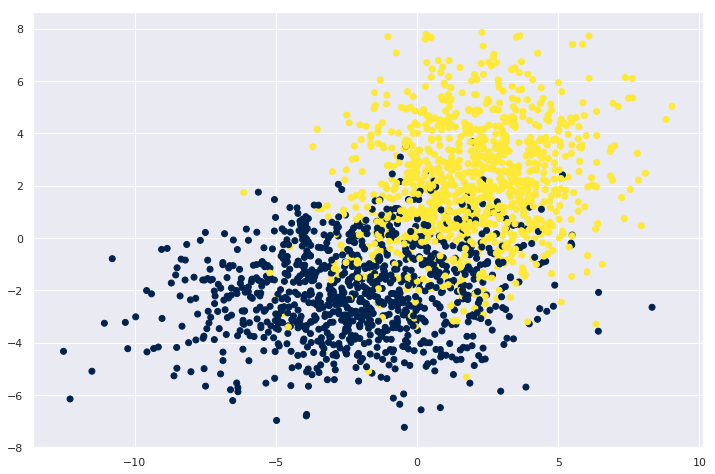

In [145]:
plot(X_syn, y_syn, x_control_syn)

In [147]:
split_size = int(X_syn.shape[0] * .6)

X_train_syn, X_test_syn = X_syn[0:split_size], X_syn[split_size:]
y_train_syn, y_test_syn = y_syn[0:split_size], y_syn[split_size:]
Z_train_syn, z_test_syn = x_control_syn[0:split_size], x_control_syn[split_size:]

In [65]:
X_train_syn, X_test_syn, y_train_syn, y_test_syn = train_test_split(X_syn, y_syn, test_size=0.33, random_state=54)

In [148]:
# Unfair
svm_syn = SupportVectorMachine(C=1, kernel=linear_kernel)
svm_syn.fit(X_train_syn, y_train_syn)
y_pred_syn = svm_syn.predict(X_test_syn)

accuracy_score(y_test_syn, y_pred_syn)

0.875

In [149]:
# Full set
svm_syn_full = SupportVectorMachine(kernel=linear_kernel)
svm_syn_full.fit(X_syn, y_syn)
y_pred_syn_full = svm_syn_full.predict(X_syn)

accuracy_score(y_syn, y_pred_syn_full)

0.866

In [75]:
# Fair
fair_svm_syn = SupportVectorMachine(kernel=linear_kernel)
fair_svm_syn.fit(X_train_syn, y_train_syn, x_control_syn['s1'])
y_pred_syn_fair = svm_syn.predict(X_test_syn)

accuracy_score(y_test_syn, y_pred_syn_fair)

ValueError: shapes (2000,) and (1340,) not aligned: 2000 (dim 0) != 1340 (dim 0)

In [ ]:
# def plot_descision_boundary(X, y, w, b):
#     xfit = np.linspace(-15, 15)
#     plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
#     plt.plot(xfit, (-w[0,0] * xfit-b[0,0])/w[1,0], '-k')
#     plt.xlim(-15, 15);

# # print(svm_syn.lagr_multipliers)
# print(svm_syn.w)
# print(svm_syn.intercept)

# # plot_descision_boundary(X_syn, y_syn, svm_syn.w, svm_syn.intercept)

In [150]:
from sklearn.svm import SVC
sk_svc_syn = SVC(gamma='auto', kernel='linear')
sk_svc_syn.fit(X_train_syn, y_train_syn)
y_pred_svc_syn = sk_svc_syn.predict(X_test_syn)

accuracy_score(y_test_syn, y_pred_svc_syn)

0.87625

In [ ]:
# print(sk_svc_syn.coef_)
# print(sk_svc_syn.intercept_)
# plot_descision_boundary(X_syn, y_syn, sk_svc_syn.coef_, sk_svc_syn.intercept_)

In [ ]:
class mySVC():
    def _init_(self):
        self.mu=[]#Lagrange multipliers
        self.w=[]# weights
        self.b=[]#bias
        
    def fit(self,X,y):
        #Initializing values and computing H. Note the 1. to force to float type
        m,n = X.shape
        y1 = np.where(y==0,-1,1) * 1. #.reshape(-1,1) * 1. #THIS IS FUNDAMENTAL
        H =  np.dot(X,X.T)*(y1.dot(y1.T))

        #Converting into cvxopt format
        P = cvxopt.matrix(H)
        q = cvxopt.matrix(-np.ones((m, 1)))
        G = cvxopt.matrix(-np.eye(m))
        h = cvxopt.matrix(np.zeros(m))
        
        A = cvxopt.matrix(y1.reshape(1, -1))
        b = cvxopt.matrix(np.zeros(1))
        #Setting solver parameters (change default to decrease tolerance) 
        cvxopt.solvers.options['show_progress'] = False
        cvxopt.solvers.options['abstol'] = 1e-10
        cvxopt.solvers.options['reltol'] = 1e-10
        cvxopt.solvers.options['feastol'] = 1e-10

        #Run solver
        sol = cvxopt.solvers.qp(P, q, G, h, A, b)
        self.mu = np.array(sol['x'])
        #w parameter in vectorized form
        self.w = ((y1 * self.mu).T @ X).reshape(-1,1)
        #Selecting the set of indices S corresponding to non zero parameters
        S = (self.mu > 1e-4).flatten()
        self.mu =self.mu[self.mu > 1e-4]

        #Computing b
#         b = y1[S] - np.dot(X[S], self.w)
        self.b = y1[S].reshape(-1,1) - np.dot(X[S], self.w)

    def predict(self,Xtest):
        return ((np.sign(Xtest.dot(self.w)+self.b)+1.0)/2.0)[:,0]